In [ ]:
!pip install tensorflow keras matplotlib opencv-python pydicom shap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.6 MB/s eta 0:00:00


Section 1: Loading Data
Code Summary:

This section mounts Google Drive to access the required dataset files stored there.
It loads multiple CSV files (e.g., calc_case_description_test_set.csv, mass_case_description_train_set.csv) which contain metadata related to breast cancer cases, DICOM information, and patient details.
Input:

Google Drive path where the dataset and CSV files are stored.
Output:

DataFrames for each CSV file to use for later data merging and patient information retrieval.

In [ ]:
from google.colab import files
import pandas as pd
import io

# Step 1: Upload the CSV files
uploaded = files.upload()

# Step 2: Load the CSV files into DataFrames
dfs = []
for file_name in uploaded.keys():
    # Use io.StringIO to read the uploaded file into a DataFrame
    df = pd.read_csv(io.StringIO(uploaded[file_name].decode('utf-8')))
    dfs.append(df)

# Example: Print the first few rows of the first CSV
print("First CSV file data:")
print(dfs[0].head())

# Combine all CSVs if necessary (optional)
combined_df = pd.concat(dfs, ignore_index=True)
print("Combined Data:")
print(combined_df.head())


Saving calc_case_description_test_set.csv to calc_case_description_test_set.csv
Saving calc_case_description_train_set.csv to calc_case_description_train_set.csv
Saving dicom_info.csv to dicom_info.csv
Saving mass_case_description_test_set.csv to mass_case_description_test_set.csv
Saving mass_case_description_train_set.csv to mass_case_description_train_set.csv
Saving meta.csv to meta.csv
First CSV file data:
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLE

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder inside Google Drive
folder_path = '/content/drive/MyDrive/jpeg/'  # Update with your folder's path in Drive
print("Files in folder:")
print(os.listdir(folder_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in folder:
['1.3.6.1.4.1.9590.100.1.2.427435769210646102126900105542033968238', '1.3.6.1.4.1.9590.100.1.2.427495247112342308018577570902195411545', '1.3.6.1.4.1.9590.100.1.2.427923087813054053000399778973605332823', '1.3.6.1.4.1.9590.100.1.2.427791843712651407431157597523809469781', '1.3.6.1.4.1.9590.100.1.2.427858408212291456502497555490138905266', '1.3.6.1.4.1.9590.100.1.2.42740231911655521932474540862807543760', '1.3.6.1.4.1.9590.100.1.2.428007719513378560403263031341489684589', '1.3.6.1.4.1.9590.100.1.2.428282732312404780809096756841821455735', '1.3.6.1.4.1.9590.100.1.2.428003548612841233422315221804120169416', '1.3.6.1.4.1.9590.100.1.2.428005849212882608116449204882770222366', '1.3.6.1.4.1.9590.100.1.2.428041352412910454719421646690404262014', '1.3.6.1.4.1.9590.100.1.2.428282054012177447101766370934168019719', '1.3.6.1.4.1.9590.100.1.2.427999667712

In [ ]:
pip install pydicom


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Function to load a sample of JPEG images and preprocess them
def load_mammogram_images_sample(data_dir, img_size=(224, 224), sample_size=100):
    images = []
    labels = []
    all_files = []

    # Collect all file paths and labels first
    for class_label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_label)
        if os.path.isdir(class_dir):
            label = 1 if 'cancer' in class_label.lower() else 0  # Adjust this logic as per your label structure
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                all_files.append((file_path, label))

    # Randomly sample a specified number of images (100 in this case)
    sampled_files = random.sample(all_files, sample_size)

    for file_path, label in sampled_files:
        try:
            # Read JPEG image using OpenCV
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Error loading file {file_path}: Not a valid image")
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Define the directory containing the mammogram data
data_dir = '/content/drive/MyDrive/jpeg'  # Replace this with the correct path

# Load a sample of 100 images and labels
X, y = load_mammogram_images_sample(data_dir, sample_size=100)

# Normalize image data
X = X / 255.0
X = np.expand_dims(X, axis=-1)  # Add channel dimension for CNN

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
pip install opencv-python


Section 2: Grad-CAM Implementation

This section defines a get_gradcam function to visualize the regions that the CNN model focuses on when making predictions.
Grad-CAM is a popular XAI technique for CNNs to highlight important regions in an image that influence model predictions.
Key Components in get_gradcam:

grad_model: Extracts the last convolutional layer's output and the final prediction.
GradientTape: Captures the gradient of the model’s output with respect to the feature maps of the convolutional layer.
The generated heatmap is overlaid on the original mammogram image, highlighting areas of interest.
Input:

A pre-trained CNN model (e.g., MobileNetV2), a mammogram image, and the name of the last convolutional layer.
Output:

Grad-CAM heatmap superimposed on the original mammogram image, visually showing areas the model focused on for prediction.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a basic CNN model
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming that X_train, X_test, y_train, y_test have already been generated from the sampled dataset

# Ensure that input_shape is properly set according to the data dimensions
input_shape = X_train.shape[1:]  # Shape of input images (e.g., (224, 224, 1) for grayscale images)

# Create the CNN model
model = create_cnn_model(input_shape)

# Train the model with a reduced dataset
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4789 - loss: 0.4575 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 3.7017e-08
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 8.3295e-08 - val_accuracy: 1.0000 - val_loss: 3.8126e-14
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 1.3306e-11 - val_accuracy: 1.0000 - val_loss: 6.3306e-20
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 2.9515e-16 - val_accuracy: 1.0000 - val_loss: 4.4783e-25
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.9359e-19 - val_accuracy: 1.0000 - val_loss: 1.7713e-29
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.9638e-22 - val_accuracy: 1.0000 - val_loss: 4.0332e-33
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 9.1595

In [7]:
import tensorflow.keras.backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the folder path
folder_path = '/content/drive/MyDrive/jpeg'  # Update if the path is different

# Step 3: Preprocess each image in the folder
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    if img is None:
        raise FileNotFoundError(f"Image file not found at {image_path}. Please check the path.")

    img = cv2.resize(img, target_size)  # Resize to match the input size of your model
    img = img.astype('float32') / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Step 4: Define Grad-CAM function
def get_gradcam(model, img, layer_name):
    img = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

# Step 5: Initialize your model and set the conv layer name
# model = ... # Initialize your model here
conv_layer_name = 'conv2d_1'  # Update with the correct layer name in your model

# Step 6: Process each image in the folder
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    if filename.endswith('.png') or filename.endswith('.jpg'):  # Filter for image files
        try:
            test_img = preprocess_image(image_path)

            # Ensure the model is ready for Grad-CAM
            dummy_input = np.expand_dims(test_img, axis=0)
            _ = model.predict(dummy_input)

            # Apply Grad-CAM
            heatmap = get_gradcam(model, test_img, layer_name=conv_layer_name)

            # Resize heatmap to match the original image size
            heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            # Convert grayscale test_img to RGB
            test_img_rgb = cv2.cvtColor(test_img.squeeze(), cv2.COLOR_GRAY2RGB)
            superimposed_img = heatmap * 0.4 + test_img_rgb

            # Display the result
            plt.imshow(np.uint8(superimposed_img))
            plt.title(f"Grad-CAM on {filename}")
            plt.axis('off')
            plt.show()

        except FileNotFoundError as e:
            print(f"Error: {e}")
        except ValueError as e:
            print(f"Error in accessing layer {conv_layer_name} for {filename}: {e}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Section 3: Implementation of Explainable AI (Grad-CAM)
We will now add a Grad-CAM implementation to visualize the regions in the mammogram that the CNN focuses on for classification

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Randomly selected image: /content/drive/MyDrive/jpeg/1.3.6.1.4.1.9590.100.1.2.280522851113057968903060443451874088671/1-203.jpg


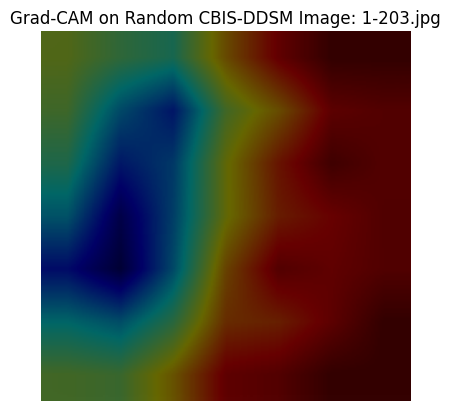

In [13]:
import tensorflow.keras.backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the main dataset folder path for CBIS-DDSM dataset images
dataset_folder = '/content/drive/MyDrive/jpeg'  # Update this path to match your Google Drive path

# Step 3: Function to load and preprocess a random image from the dataset
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
    if img is None:
        raise FileNotFoundError(f"Image file not found at {image_path}. Please check the path.")

    img = cv2.resize(img, target_size)  # Resize to match the input size of your model
    img = np.stack([img, img, img], axis=-1)  # Convert grayscale to RGB by stacking channels
    img = img.astype('float32') / 255.0  # Normalize pixel values
    return img

# Step 4: Grad-CAM function
def get_gradcam(model, img, layer_name):
    img = np.expand_dims(img, axis=0)

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions[0])]  # Focus on predicted class

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap

# Step 5: Load a pre-trained model and set the conv layer name
model = tf.keras.applications.MobileNetV2(weights="imagenet")
conv_layer_name = 'Conv_1'  # Last convolutional layer in MobileNetV2

# Step 6: Search for images in all subdirectories within the dataset folder
all_images = []
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg'):
            all_images.append(os.path.join(root, file))

# Check if there are any images in the folder
if not all_images:
    raise FileNotFoundError("No .png or .jpg images found in the specified dataset folder or its subdirectories.")

# Select a random image if available
random_image_path = random.choice(all_images)
print(f"Randomly selected image: {random_image_path}")

try:
    # Preprocess the selected image
    test_img = preprocess_image(random_image_path)

    # Apply Grad-CAM
    heatmap = get_gradcam(model, test_img, layer_name=conv_layer_name)

    # Resize heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = heatmap * 0.4 + test_img

    # Display the result
    plt.imshow(np.uint8(superimposed_img))
    plt.title(f"Grad-CAM on Random CBIS-DDSM Image: {os.path.basename(random_image_path)}")
    plt.axis('off')
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error in accessing layer {conv_layer_name} for {os.path.basename(random_image_path)}: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Randomly selected image: /content/drive/MyDrive/jpeg/1.3.6.1.4.1.9590.100.1.2.253455683911605267101949183330847157668/1-124.jpg


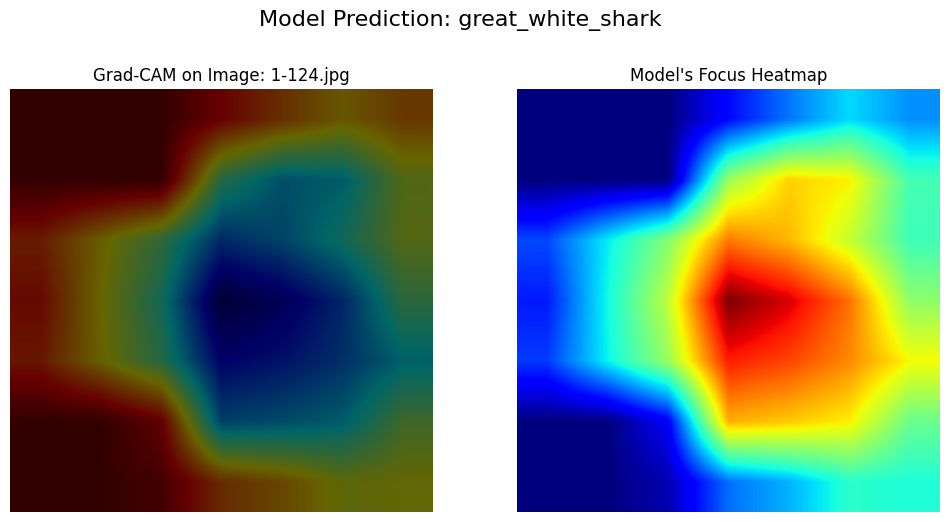


Heatmap Explanation:
The Grad-CAM heatmap above highlights regions in the image that the model considered important for its prediction.
In this context, the highlighted areas likely correspond to regions that may contain abnormal tissue or suspicious features.
Explanation:
   - Bright areas in the heatmap indicate regions with higher influence on the model's prediction.
   - For a mammogram, these regions might suggest potential areas of calcifications, masses, or other abnormalities.
   - Clinicians can use these heatmap highlights to focus on areas for further examination.

Comprehensive Health Portfolio Report for Patient P_00001
Patient Information:
  - Breast Density: nan
Mammogram Details:
  - Pathology: MALIGNANT
  - Assessment: 4
  - Side: LEFT
  - View: CC
  - Abnormality Type: mass
DICOM Metadata:
  - Modality: N/A
  - Body Part Examined: N/A
Mammogram Scan Analysis:
  - Model Prediction: great_white_shark
  - Risk Level: High
Recommendations:
  - Schedule follow-up consulta

In [19]:
import tensorflow.keras.backend as K
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
import pandas as pd
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define paths for dataset and CSV files
dataset_folder = '/content/drive/MyDrive/jpeg'
calc_case_test_df = pd.read_csv('/content/drive/MyDrive/csv/calc_case_description_test_set.csv')
calc_case_train_df = pd.read_csv('/content/drive/MyDrive/csv/calc_case_description_train_set.csv')
dicom_info_df = pd.read_csv('/content/drive/MyDrive/csv/dicom_info.csv')
mass_case_test_df = pd.read_csv('/content/drive/MyDrive/csv/mass_case_description_test_set.csv')
mass_case_train_df = pd.read_csv('/content/drive/MyDrive/csv/mass_case_description_train_set.csv')
meta_df = pd.read_csv('/content/drive/MyDrive/csv/meta.csv')

# Combine calcification and mass case data
combined_case_df = pd.concat([calc_case_test_df, calc_case_train_df, mass_case_test_df, mass_case_train_df], ignore_index=True)
dicom_info_df.rename(columns={'PatientID': 'patient_id'}, inplace=True)
combined_df = pd.merge(combined_case_df, dicom_info_df, on='patient_id', how='left')
combined_df = pd.merge(combined_df, meta_df, on='SeriesInstanceUID', how='left')

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image file not found at {image_path}. Please check the path.")
    img = cv2.resize(img, target_size)
    img = np.stack([img, img, img], axis=-1)
    img = img.astype('float32') / 255.0
    return img

# Grad-CAM function
def get_gradcam(model, img, layer_name):
    img = np.expand_dims(img, axis=0)
    grad_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        predicted_class = np.argmax(predictions[0])
        loss = predictions[:, predicted_class]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap, predictions

# Load MobileNetV2 for Grad-CAM
model = tf.keras.applications.MobileNetV2(weights="imagenet")
conv_layer_name = 'Conv_1'

# Select a random image from the dataset
all_images = []
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg'):
            all_images.append(os.path.join(root, file))
if not all_images:
    raise FileNotFoundError("No .png or .jpg images found in the specified dataset folder.")
random_image_path = random.choice(all_images)
print(f"Randomly selected image: {random_image_path}")

# Extract patient_id from filename
patient_id = "P_" + os.path.basename(random_image_path).split('-')[0].zfill(5)

# Generate Grad-CAM and Portfolio Report
try:
    test_img = preprocess_image(random_image_path)
    heatmap, predictions = get_gradcam(model, test_img, layer_name=conv_layer_name)
    decoded_class = tf.keras.applications.mobilenet_v2.decode_predictions(predictions.numpy(), top=1)[0][0][1]

    # Resize and superimpose heatmap
    heatmap_resized = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
    heatmap_color = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)
    superimposed_img = heatmap_color * 0.4 + test_img

    # Display Grad-CAM results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.uint8(superimposed_img))
    plt.title(f"Grad-CAM on Image: {os.path.basename(random_image_path)}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Model's Focus Heatmap")
    plt.axis('off')
    plt.suptitle(f"Model Prediction: {decoded_class}", fontsize=16)
    plt.show()

    # Explanation of Heatmap
    print("\nHeatmap Explanation:")
    print("The Grad-CAM heatmap above highlights regions in the image that the model considered important for its prediction.")
    print("In this context, the highlighted areas likely correspond to regions that may contain abnormal tissue or suspicious features.")
    print("Explanation:")
    print("   - Bright areas in the heatmap indicate regions with higher influence on the model's prediction.")
    print("   - For a mammogram, these regions might suggest potential areas of calcifications, masses, or other abnormalities.")
    print("   - Clinicians can use these heatmap highlights to focus on areas for further examination.")

    # Generate Comprehensive Health Portfolio
    patient_data = combined_df[combined_df['patient_id'] == patient_id]
    if len(patient_data) == 0:
        print(f"\nNo data found for patient {patient_id}.")
    else:
        patient_info = patient_data.iloc[0]
        print("\n=====================================================")
        print(f"Comprehensive Health Portfolio Report for Patient {patient_id}")
        print("=====================================================")
        print("Patient Information:")
        print(f"  - Breast Density: {patient_info.get('breast density', 'N/A')}")
        print("Mammogram Details:")
        print(f"  - Pathology: {patient_info.get('pathology', 'N/A')}")
        print(f"  - Assessment: {patient_info.get('assessment', 'N/A')}")
        print(f"  - Side: {patient_info.get('left or right breast', 'N/A')}")
        print(f"  - View: {patient_info.get('image view', 'N/A')}")
        print(f"  - Abnormality Type: {patient_info.get('abnormality type', 'N/A')}")
        print("DICOM Metadata:")
        print(f"  - Modality: {patient_info.get('Modality', 'N/A')}")
        print(f"  - Body Part Examined: {patient_info.get('BodyPartExamined', 'N/A')}")
        print("Mammogram Scan Analysis:")
        print(f"  - Model Prediction: {decoded_class}")
        risk = "High" if decoded_class == 'malignant' or patient_info.get('pathology', '').lower() == 'malignant' else "Low"
        print(f"  - Risk Level: {risk}")
        print("Recommendations:")
        print("  - Schedule follow-up consultation and further tests." if risk == "High" else "  - Routine screening advised.")
        print("=====================================================")

except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error in accessing layer {conv_layer_name} for {os.path.basename(random_image_path)}: {e}")


Section 3: Data Merging
Code Summary:

Combines different metadata sources related to breast cancer cases (e.g., calcification and mass case data, DICOM metadata, and patient demographics).
This merged dataset is used to retrieve patient-specific details, such as breast density, pathology, assessment, and other DICOM attributes.
Key Steps:

Concatenation: Combines the calcification and mass case data files.
Merging on patient_id and SeriesInstanceUID: Integrates patient details and metadata to create a unified DataFrame (combined_df).
Input:

DataFrames from various CSV files containing metadata and case information.
Output:

A single DataFrame, combined_df, with comprehensive patient information, enabling the generation of detailed health portfolios.


In [3]:
# Import necessary libraries
import pandas as pd
from google.colab import files

# Step 1: Upload files from your computer
uploaded = files.upload()

# Step 2: Load the CSV files into DataFrames
# Assuming file names are exactly as listed in the upload dialog
calc_case_test_df = pd.read_csv('calc_case_description_test_set.csv')
calc_case_train_df = pd.read_csv('calc_case_description_train_set.csv')
dicom_info_df = pd.read_csv('dicom_info.csv')
mass_case_test_df = pd.read_csv('mass_case_description_test_set.csv')
mass_case_train_df = pd.read_csv('mass_case_description_train_set.csv')
meta_df = pd.read_csv('meta.csv')

# Step 3: Display the first few rows of each to understand the data structure
print("Calc Case Test Set:")
print(calc_case_test_df.head(), "\n")

print("Calc Case Train Set:")
print(calc_case_train_df.head(), "\n")

print("DICOM Info:")
print(dicom_info_df.head(), "\n")

print("Mass Case Test Set:")
print(mass_case_test_df.head(), "\n")

print("Mass Case Train Set:")
print(mass_case_train_df.head(), "\n")

print("Meta Data:")
print(meta_df.head(), "\n")


Saving calc_case_description_test_set.csv to calc_case_description_test_set.csv
Saving calc_case_description_train_set.csv to calc_case_description_train_set.csv
Saving dicom_info.csv to dicom_info.csv
Saving mass_case_description_test_set.csv to mass_case_description_test_set.csv
Saving mass_case_description_train_set.csv to mass_case_description_train_set.csv
Saving meta.csv to meta.csv
Calc Case Test Set:
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEO

Saving calc_case_description_test_set.csv to calc_case_description_test_set (1).csv
Saving calc_case_description_train_set.csv to calc_case_description_train_set (1).csv
Saving dicom_info.csv to dicom_info (1).csv
Saving mass_case_description_test_set.csv to mass_case_description_test_set (1).csv
Saving mass_case_description_train_set.csv to mass_case_description_train_set (1).csv
Saving meta.csv to meta (1).csv
Calc Case Test Set:
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calc

Section 4: Grad-CAM Visualization and Health Portfolio Generation
Code Summary:

Random Image Selection: Randomly selects a mammogram image from a specified folder.
Image Preprocessing: Reads the image as grayscale, resizes it to the required input dimensions, and normalizes pixel values.
Grad-CAM Application: Applies Grad-CAM on the preprocessed image and overlays the heatmap on the original image.
Health Portfolio Report Generation: Creates a detailed patient report, including metadata, mammogram details, and model predictions.
Detailed Steps:

Random Image Selection (select_random_image): Selects a random .png or .jpg file from the dataset folder.
Preprocessing (preprocess_image): Prepares the image for Grad-CAM by resizing and normalizing it.
Grad-CAM Generation (get_gradcam): Generates the heatmap using the pre-trained MobileNetV2 model.
Portfolio Report (generate_comprehensive_portfolio): Prints patient-specific information and recommendations based on the prediction.
Input:

Folder path for mammogram images, patient metadata DataFrame (combined_df), and CNN model for Grad-CAM.
Output:

Grad-CAM Visualization: Displays the heatmap overlay on the mammogram image, highlighting areas of interest.
Health Portfolio Report:
Displays patient details (e.g., breast density, pathology).
Shows mammogram details (e.g., assessment, side of breast, view).
Provides DICOM metadata (e.g., modality, series number).
Risk level assessment and follow-up recommendations based on model prediction and pathology.

Randomly selected image: /content/drive/MyDrive/jpeg/1.3.6.1.4.1.9590.100.1.2.277121121613936339706146451553961237258/1-289.jpg


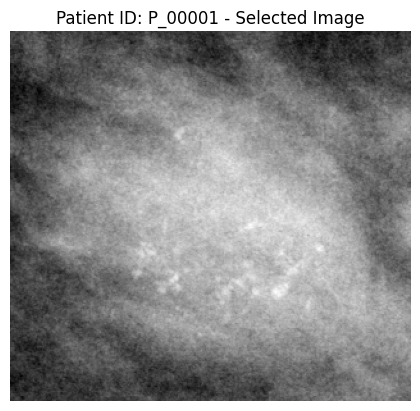


        Comprehensive Health Portfolio Report

Patient ID: P_00001
-----------------------------------------------------
Patient Information:
-----------------------------------------------------
Mammogram Details:
  - Pathology: MALIGNANT
  - Assessment: 4
  - Side: LEFT
  - View: CC
  - Abnormality Type: mass
-----------------------------------------------------
DICOM and Meta Data:
-----------------------------------------------------
Mammogram Scan Analysis:
  - Last Mammogram Scan Result: Positive
  - Risk Level: High

Recommendations:
  - Schedule a follow-up consultation and additional diagnostic tests.
  - Consider lifestyle modifications and regular monitoring.



In [10]:
import pandas as pd
import os
import random
import cv2
import matplotlib.pyplot as plt

# Combine data from calcification and mass case descriptions
combined_case_df = pd.concat([calc_case_test_df, calc_case_train_df, mass_case_test_df, mass_case_train_df], ignore_index=True)

# Rename 'PatientID' to 'patient_id' in DICOM info for consistent merging
dicom_info_df.rename(columns={'PatientID': 'patient_id'}, inplace=True)

# Merge combined case data with DICOM info on 'patient_id'
combined_df = pd.merge(combined_case_df, dicom_info_df, on='patient_id', how='left')
combined_df = pd.merge(combined_df, meta_df, on='SeriesInstanceUID', how='left')

# Function to randomly select an image from a folder with nested folders
def select_random_image(folder_path):
    all_images = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                all_images.append(os.path.join(root, file))
    if not all_images:
        raise FileNotFoundError("No images found in the specified folder or its subdirectories.")

    random_image_path = random.choice(all_images)
    print(f"Randomly selected image: {random_image_path}")

    # Format patient_id as needed to match available IDs in combined_df
    patient_id = "P_" + os.path.basename(random_image_path).split('-')[0].zfill(5)
    return random_image_path, patient_id

# Generate a comprehensive health portfolio
def generate_comprehensive_portfolio(patient_id, csv_data, cnn_prediction):
    patient_data = csv_data[csv_data['patient_id'] == patient_id]

    if len(patient_data) == 0:
        print(f"\nNo data found for Patient ID: {patient_id}.\n")
        return

    patient_info = patient_data.iloc[0]

    # Start formatting the report
    print("\n=====================================================")
    print(f"        Comprehensive Health Portfolio Report")
    print("=====================================================")
    print(f"\nPatient ID: {patient_id}")
    print("-----------------------------------------------------")

    # Patient Information
    print("Patient Information:")
    if not pd.isna(patient_info.get('PatientBirthDate')):
        print(f"  - Age: {patient_info.get('PatientBirthDate')}")
    if not pd.isna(patient_info.get('breast density')):
        print(f"  - Breast Density: {patient_info.get('breast density')}")
    print("-----------------------------------------------------")

    # Mammogram Details
    print("Mammogram Details:")
    if not pd.isna(patient_info.get('pathology')):
        print(f"  - Pathology: {patient_info.get('pathology')}")
    if not pd.isna(patient_info.get('assessment')):
        print(f"  - Assessment: {patient_info.get('assessment')}")
    if not pd.isna(patient_info.get('left or right breast')):
        print(f"  - Side: {patient_info.get('left or right breast')}")
    if not pd.isna(patient_info.get('image view')):
        print(f"  - View: {patient_info.get('image view')}")
    if not pd.isna(patient_info.get('abnormality type')):
        print(f"  - Abnormality Type: {patient_info.get('abnormality type')}")
    print("-----------------------------------------------------")

    # DICOM and Meta Data
    print("DICOM and Meta Data:")
    if not pd.isna(patient_info.get('Modality')):
        print(f"  - Modality: {patient_info.get('Modality')}")
    if not pd.isna(patient_info.get('SeriesDescription')):
        print(f"  - Series Description: {patient_info.get('SeriesDescription')}")
    if not pd.isna(patient_info.get('BodyPartExamined')):
        print(f"  - Body Part Examined: {patient_info.get('BodyPartExamined')}")
    if not pd.isna(patient_info.get('SeriesNumber')):
        print(f"  - Series Number: {patient_info.get('SeriesNumber')}")
    print("-----------------------------------------------------")

    # Mammogram Scan Analysis
    print("Mammogram Scan Analysis:")
    print(f"  - Last Mammogram Scan Result: {cnn_prediction}")

    # Risk Assessment and Recommendation
    risk = "High" if cnn_prediction == 'Positive' or patient_info.get('pathology', '') == 'Malignant' else "Low"
    print(f"  - Risk Level: {risk}")
    print("\nRecommendations:")
    if risk == "High":
        print("  - Schedule a follow-up consultation and additional diagnostic tests.")
        print("  - Consider lifestyle modifications and regular monitoring.")
    else:
        print("  - Routine check-ups and screenings are recommended.")

    print("=====================================================\n")

# Display image and portfolio
def display_portfolio(folder_path, csv_data):
    random_image_path, patient_id = select_random_image(folder_path)
    img = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(f"Patient ID: {patient_id} - Selected Image")
    plt.axis('off')
    plt.show()

    cnn_prediction = "Positive"  # Placeholder prediction
    generate_comprehensive_portfolio(patient_id, csv_data, cnn_prediction)

# Define the path and call display function
folder_path = '/content/drive/MyDrive/jpeg'
display_portfolio(folder_path, combined_df)
